## Project: **Vehicle Detection** 

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


#### Import Packages

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from skimage.feature import hog

# inline plots
%matplotlib inline 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### For suppressing sklearn warning regarding version

In [30]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Feature Extraction & Classifier Training

#### Helper functions for feature exraction

In [7]:
# Color space conversion
def convert_color(img, conv='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
    return feature_image
    

# Obtain HOG features
# Call with (vis=FALSE and feature_vec=FALSE) for entire region of interest
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# Obtain bin spatial features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Obtain histogram features
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


#### Feature extraction procedure for single image

In [8]:
# Define a function to extract features from a single image window
def single_img_features(img, 
                        color_space='RGB', 
                        spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        hog_vis=False, hog_feat_vec=False):
                            
    # Define an empty list to receive features
    img_features = []
    
    # Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)
    
    # Compute spatial features and append to list, if flag is set 
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    # Compute histogram features and append to list, if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    # Compute HOG features and append to list, if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=hog_vis, feature_vec=hog_feat_vec))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=hog_vis, feature_vec=hog_feat_vec)
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)


#### Feature extraction procedure for multiple images

In [9]:
def extract_features(img_filenames, 
                        color_space='RGB', 
                        spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        hog_vis=False, hog_feat_vec=True):

    # Create a list to append feature vectors to
    features = []

    # Iterate over each image 
    for filename in img_filenames:
        
        # Read in image
        img = mpimg.imread(filename)
        
        # Delegate to single_img_features
        img_features = single_img_features(
            img, color_space=color_space, 
            spatial_size=spatial_size,
            hist_bins=hist_bins, orient=orient, 
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
            hog_channel=hog_channel,
            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
            hog_vis=hog_vis, hog_feat_vec=hog_feat_vec)
        
        # Append features to list
        features.append(img_features)
    
    return features


#### Build a list of images in the dataset

In [13]:
# Read non-vehicles images
nc_images = glob.glob('non-vehicles/*/*.png')
notcars = []
for image in nc_images:
    notcars.append(image)
print('%d non-vehicle images' % len(nc_images))

# Read vehicles images
c_images = glob.glob('vehicles/*/*.png')
cars = []
for image in c_images:
    cars.append(image)
print('%d vehicle images' % len(c_images))

8968 non-vehicle images
8792 vehicle images


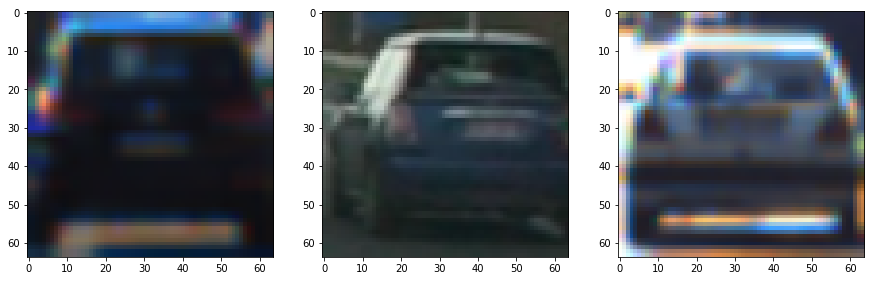

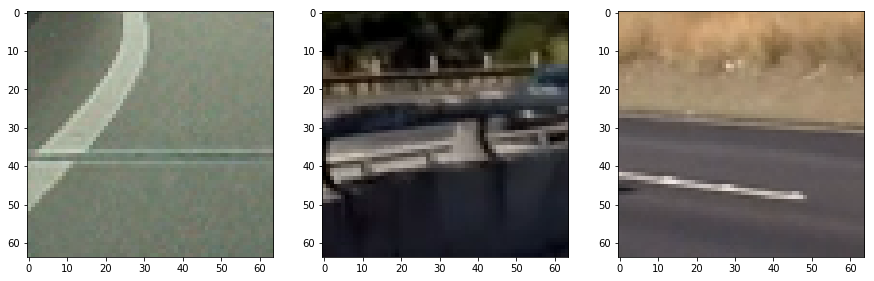

In [269]:
# Examples of 'vehicle' class
fig = plt.figure()
plt.subplot(131)
plt.imshow(mpimg.imread(c_images[3003]))
plt.subplot(132)
plt.imshow(mpimg.imread(c_images[44]))
plt.subplot(133)
plt.imshow(mpimg.imread(c_images[7002]))

# Examples of 'non-vehicle' class
# Examples of each class
fig = plt.figure()
plt.subplot(131)
plt.imshow(mpimg.imread(nc_images[33]))
plt.subplot(132)
plt.imshow(mpimg.imread(nc_images[6004]))
plt.subplot(133)
plt.imshow(mpimg.imread(nc_images[7002]))

#### Parameters

In [15]:
color_space = 'YCrCb' #'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18 #9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [400, None] # Min and max in y to search in slide_window()

#### Sample Visualization of HOG features
Refered to visualization scheme done in https://github.com/tatsuyah/vehicle-detection

Text(0.5,1,'Not-car channel 0 HOG features')

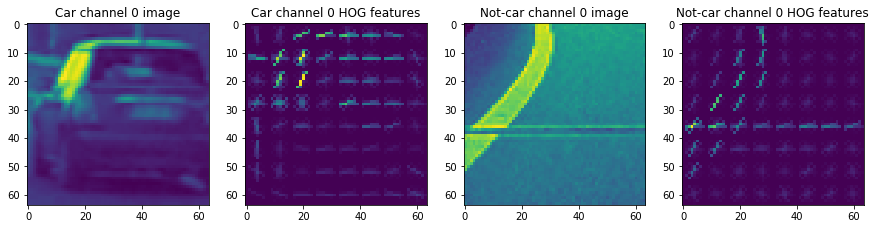

In [314]:
car_img = mpimg.imread(c_images[44])
car_img_ch0 = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)[:,:,0]
car_hog_feature, car_hog_image = get_hog_features(car_img_ch0, 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
car_img_features = cv2.resize(car_img_ch0, spatial_size)

notcar_img = mpimg.imread(nc_images[33])
notcar_img_ch0 = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)[:,:,0]
notcar_hog_feature, notcar_hog_image = get_hog_features(notcar_img_ch0, 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
notcar_img_features = cv2.resize(notcar_img_ch0, spatial_size)


fig = plt.figure()
plt.subplot(141)
plt.imshow(car_img_ch0)
plt.title('Car channel 0 image')
plt.subplot(142)
plt.imshow(car_hog_image)
plt.title('Car channel 0 HOG features')

plt.subplot(143)
plt.imshow(notcar_img_ch0)
plt.title('Not-car channel 0 image')
plt.subplot(144)
plt.imshow(notcar_hog_image)
plt.title('Not-car channel 0 HOG features')



#### Extract features from dataset

In [16]:
# Extract features from non-car images
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, hog_feat_vec = True)

In [17]:
# Extract features from car images
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, hog_feat_vec = True)

In [18]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print('Feature vector shape: %s' % str(X.shape))
print('Labels vector shape: %s' % str(y.shape))

Feature vector shape: (17760, 11400)
Labels vector shape: (17760,)


#### Split up data into randomized training and test sets

In [19]:
from sklearn.model_selection import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('X_train.shape: %s' % str(X_train.shape))
print('y_train.shape: %s' % str(y_train.shape))
print('X_test.shape: %s' % str(X_test.shape))
print('y_test.shape: %s' % str(y_test.shape))

X_train.shape: (14208, 11400)
y_train.shape: (14208,)
X_test.shape: (3552, 11400)
y_test.shape: (3552,)


#### Normalize features to zero mean and unit variance

In [20]:
from sklearn.preprocessing import StandardScaler
    
# Fit a per-column scaler on train set and apply to X
# Note that the split has been done prior to scaling
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

#### Train LinearSVC

In [21]:
from sklearn.svm import LinearSVC
import time

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

# Print training time and accuracty on test set
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11400
7.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9924


### Vehicle Detection (test images)

#### Sliding Window Search with HOG sub-sampling

In [331]:
from collections import deque

win_size = 64
# Find promising bounding boxes using HOG sub-sampling and make predictions
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, win_sizes):
    
    bbox_detected = []
    
    # Set up image to draw on
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    # win_sizes contain varying window sizes to check, i.e, [32, 64] indicate to use windows of (32x32) and (64x64)
    for scale in scales:    

        # Specify region of interest
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        # Name channels of region of interest
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps of window search
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        #window = win_size
        pix_per_cell - cell_per_block + 1
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        # Perform prediction for each "window"
        for xb in range(nxsteps):
            for yb in range(nysteps):

                # Identify position in image
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                # Identify window corner
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (win_size, win_size))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                # If detected, obtain the correspoinding window and append to list of bounding boxes
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    bbox_detected.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
            
    return draw_img, bbox_detected

#### Heatmap thresholding for removing false positives

In [332]:
# Annotates frequency of detection based on of bounding boxes
# Assumes each "box" takes the form ((x1, y1), (x2, y2))
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

# Thresholds areas without sufficient "heat"
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0     # Zero out pixels below the threshold
    return heatmap

#### Utility for drawing bounding box in given image

In [333]:
# Draws bounding box around cars in image
def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):

        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    
    return img


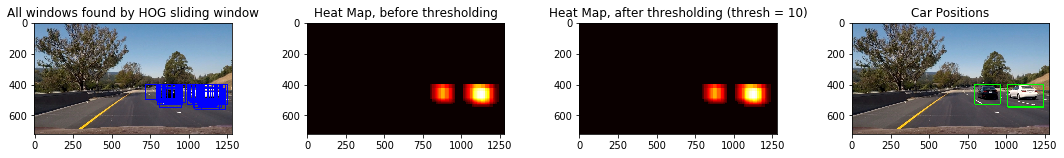

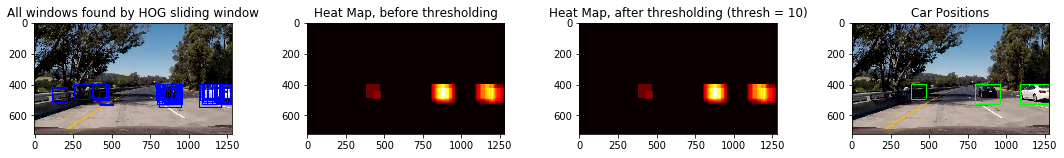

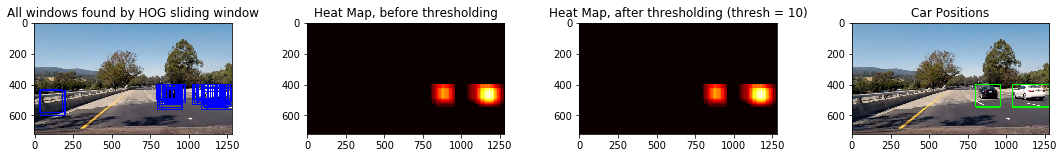

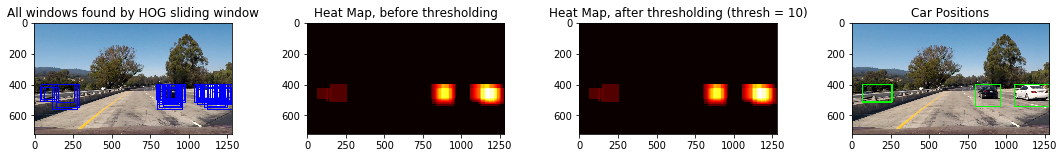

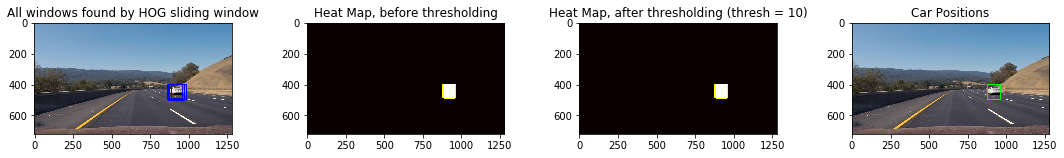

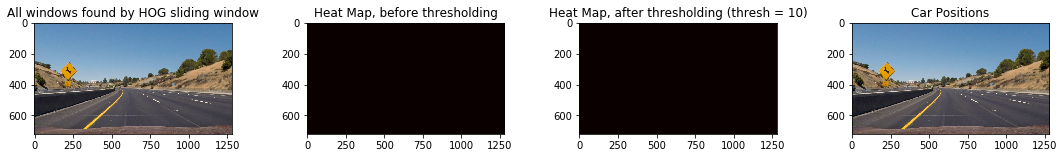

In [354]:
from scipy.ndimage.measurements import label

# Sliding Window Params
heat_thresh = 10
#win_sizes = [48, 64, 80, 96, 128, 192, 256]
#win_sizes = [96, 128, 192]
win_sizes = [64]
#scales = [1.0, 1.2, 1.3, 1.5, 2, 2.4]
#scales = [1.0, 1.5, 1.8, 2, 2.3]
scales = [1.4, 1.5, 1.6, 1.8, 2, 2.3, 2.5]

# Read images from test directory
test_images = glob.glob('test_images/*.jpg')
for image in test_images:

    # Apply HOG window search and obtain candidate bounding boxes
    img = mpimg.imread(image)
    win_img, bbox_list = find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, win_sizes)

    # Obtain heat map of box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)    
    heat_pre_thresh = add_heat(heat,bbox_list)

    # Reinforce window overlaps
    # Referenced https://discussions.udacity.com/t/final-bounding-boxes-on-test-images-does-not-completely-enclose-the-car/238416/13
    for box in bbox_list:
        if np.max(heat_pre_thresh[box[0][1]:box[1][1], box[0][0]:box[1][0]]) > 1:
            heat_pre_thresh[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 3

    # Apply threshold to help remove false positives
    heat_post_thresh = apply_threshold(heat_pre_thresh, heat_thresh)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_post_thresh, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    fig = plt.figure()
    plt.subplot(141)
    plt.imshow(win_img)
    plt.title('All windows found by HOG sliding window')
    plt.subplot(142)
    plt.imshow(heat_pre_thresh, cmap='hot') 
    plt.title('Heat Map, before thresholding') 
    plt.subplot(143)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map, after thresholding (thresh = ' + str(heat_thresh) + ')')
    plt.subplot(144)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    fig.tight_layout()

### Vehicle Detection (video)

In [348]:
#scales = [1.5, 1.8, 2, 2.3, 2.5]
scales = [1.4, 1.5, 1.6, 1.8, 2, 2.3]

def detect_process(img):
    
    global heatmap_deque

    # Apply HOG sub-sample sliding window to find "hot" windows
    win_img, bbox_list = find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, win_sizes = [32, 64])

    # Obtain heat map of box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Average heatmap with recent previous-N heatmaps for smoothing
    heatmap_deque.append(heatmap)
    heatmap_avg = np.average(np.array(heatmap_deque), axis=0)    
    
    # Additional thresholding to eliminate false positives...
    #heatmap_avg = apply_threshold(heatmap_avg, 0.5)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap_avg)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img


In [360]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
import os

input_dir = './'
output_dir = './test_videos_output/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#filename = 'test_video.mp4'
filename = 'project_video.mp4'

heatmap_deque = deque(maxlen=15)

# First bridge - lighter colorerd road, relatively straight
#clip1 = VideoFileClip(input_dir + filename).subclip(17,27)

# Second bridge - lighter colored road, curved, shadows
#clip1 = VideoFileClip(input_dir + filename).subclip(3,4)

# Full Clip
clip1 = VideoFileClip(input_dir + filename)

white_clip = clip1.fl_image(detect_process) #
%time white_clip.write_videofile(output_dir + filename, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_dir + filename))

[MoviePy] >>>> Building video ./test_videos_output/project_video.mp4
[MoviePy] Writing video ./test_videos_output/project_video.mp4



  0%|          | 3/1261 [00:09<1:04:03,  3.06s/it]


KeyboardInterrupt: 